# Benchmark simulation
In this tutorial we will solve a single phase flow problem defined in Section 4.1 of [Flemisch et al. 2017](https://doi.org/10.1016/j.advwatres.2017.10.036). The simulation is based on the `SinglePhaseFlow` class, which is introduced in [this tutorial](./single_phase_flow.ipynb). We modify the model through domain, boundary conditions and constitutive laws. 
We also specify fluid and solid parameters. 

In addition to providing a runable setup for the benchmark problem, the tutorial illustrates a non-trivial extension to dimension-dependent permeability.

We start off by importing the necessary packages, and make a shorthand for the single phase flow model class:

In [17]:
import porepy as pp
import numpy as np
from porepy.models.fluid_mass_balance import SinglePhaseFlow

### Geometry
The default geometry is a unitary domain without any fractures. The benchmark problem is defined on the unit square, but contains a set of fractures which we access in PorePy's library of fracture sets. Specifications on how to mesh the domain will be passed as parameters below.

We also define the boundary conditions to be of Dirichlet type on the west and east boundary with pressure values of 1 and 0, respectively.

In [18]:
class BenchmarkGeometry:
    def set_fractures(self) -> None:
        """Setting a diagonal fracture"""
        self._fractures = pp.applications.md_grids.fracture_sets.benchmark_regular_2d_fractures()


class BenchmarkBCs:
    def bc_type_darcy_flux(self, sd: pp.Grid) -> pp.BoundaryCondition:
        """Assign dirichlet to the west and east boundaries. The rest are Neumann by default."""
        bounds = self.domain_boundary_sides(sd)
        bc = pp.BoundaryCondition(sd, bounds.west + bounds.east, "dir")
        return bc

    def bc_values_pressure(self, boundary_grid: pp.BoundaryGrid) -> np.ndarray:
        """Zero bc value on top, bottom and east, 1 on west side."""
        bounds = self.domain_boundary_sides(boundary_grid)
        values = np.zeros(boundary_grid.num_cells)
        # See section on scaling for explanation of the conversion.
        values[bounds.west] = self.fluid.convert_units(1, "Pa")
        return values

To complete the modifications to the `SinglePhaseFlow` model, we need to implement different permeability values depending on subdomain dimension. Something similar is implemented in the `CubicLawPermeability` class, but our needs are not quite met. Here, we add separate methods for each dimension and apply values from the passed parameters for fractures and intersections.  

In [19]:
class DimensionDependentPermeability(pp.constitutive_laws.ConstantPermeability):
    """Permeability depending on subdomain dimension."""

    def permeability(self, subdomains: list[pp.Grid]) -> pp.ad.Operator:
        """Permeability [m^2].

        This function combines the permeability of the matrix, fractures and
        intersections.

        Parameters:
            subdomains: List of subdomains.

        Returns:
            Cell-wise permeability values.

        """
        projection = pp.ad.SubdomainProjections(subdomains, dim=1)
        matrix = [sd for sd in subdomains if sd.dim == self.nd]
        fractures: list[pp.Grid] = [
            sd for sd in subdomains if sd.dim == self.nd - 1
        ]
        intersections: list[pp.Grid] = [
            sd for sd in subdomains if sd.dim < self.nd - 1
        ]

        permeability = projection.cell_prolongation(matrix) @ self.matrix_permeability(
            matrix
        ) + projection.cell_prolongation(
            fractures
        ) @ self.fracture_permeability(
            fractures
        ) + projection.cell_prolongation(
            intersections
        ) @ self.intersection_permeability(
            intersections
        )
        return permeability


    def matrix_permeability(self, subdomains: list[pp.Grid]) -> pp.ad.Operator:
        """Permeability of the matrix.

        Parameters:
            subdomains: List of subdomains.

        Returns:
            Cell-wise permeability operator.

        """
        return super().permeability(subdomains)  # One by default.

    def fracture_permeability(self, subdomains: list[pp.Grid]) -> pp.ad.Operator:
        """Permeability of fractures.

        Parameters:
            subdomains: List of subdomains.

        Returns:
            Cell-wise permeability operator.

        """
        size = sum([sd.num_cells for sd in subdomains])
        val = self.params.get("fracture_permeability", 1e-4)
        return pp.wrap_as_dense_ad_array(self.solid.convert_units(val, "m^2"), size)

    def intersection_permeability(self, subdomains: list[pp.Grid]) -> pp.ad.Operator:
        """Permeability of intersections.

        Parameters:
            subdomains: List of subdomains.

        Returns:
            Cell-wise permeability operator.

        """
        size = sum([sd.num_cells for sd in subdomains])
        val = self.params.get("intersection_permeability", 1e-4)
        return pp.wrap_as_dense_ad_array(self.solid.convert_units(val, "m^2"), size)


We can now combine the extensions with the base class:

In [20]:
class BenchmarkModel(
    BenchmarkGeometry,
    BenchmarkBCs,
    DimensionDependentPermeability,
    SinglePhaseFlow,
):
    """Combines all SinglePhaseFlow with adjustments as defined in the benchmark problem."""

We run the with both of the fracture permeability values defined in the benchmark. We also change the grid type for good measure.

c:\users\ist050\onedrive - university of bergen\documents\github\porepy\src\porepy\grids\mortar_grid.py:786: UserWarning: Is it really meaningful to ask for signs of a one sided mortar grid?
  warnings.warn(


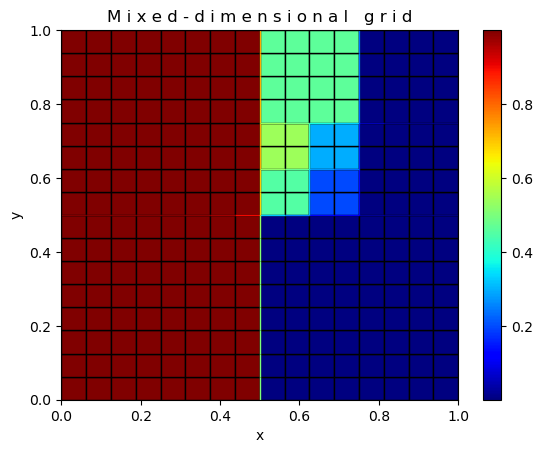

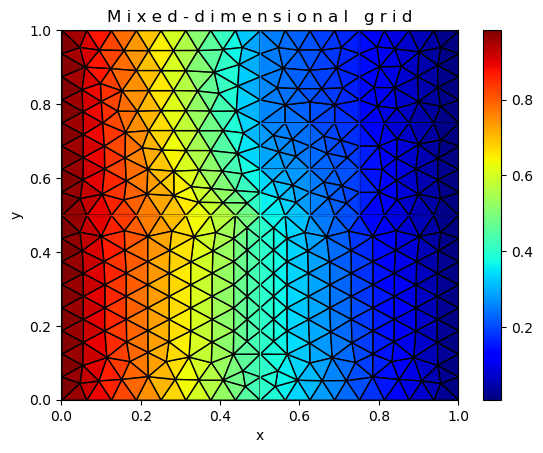

In [26]:
for k_f, grid_type in zip([1e-4, 1e4], ["cartesian", "simplex"]):
    # We use default fluid parameters but tailored solid parameters.
    solid_constants = pp.SolidConstants({"aperture": 1e-4, "normal_permeability": k_f})
    params = {
        "fracture_permeability": k_f,
        "intersection_permeability": k_f,
        "material_constants": {"solid": solid_constants},
        "grid_type": grid_type,
        "meshing_arguments": {"cell_size": 1/16}
    }
    model = BenchmarkModel(params)
    pp.run_time_dependent_model(model, params)
    pp.plot_grid(model.mdg, model.pressure_variable, figsize=(10, 8), plot_2d=True)